**Implementation of a Mask R-CNN algorithm**
---

In this Notebook, I implement a state-of-the-art Mask R-CNN in order to proceed person detection.
The Mask R-CNN efficiently detects objects within an image and provides a class, a bounding box and a mask for all those objects.

### **0.0 Libraries importation and setup**

In [ ]:
!git clone https://github.com/Thomas-Gentilhomme/AI-Project.git

Cloning into 'AI-Project'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 111 (delta 3), reused 8 (delta 3), pack-reused 101
Receiving objects: 100% (111/111), 73.71 MiB | 11.24 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
%tensorflow_version 1.x
%cd AI-Project/mask_rcnn

TensorFlow 1.x selected.
/content/AI-Project/mask_rcnn


In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


## **Section 1 - Data Preparation**


### **1.1 Load dataset**

In [ ]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

### **1.2 Extract frames from videos**

## **Section 2 - Model Implementation**

In [ ]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [ ]:
def keep_persons(results):
  #persons = {'rois': np.array([], dtype=np.int32), 'class_ids': np.array([], dtype=np.int32), 'scores': np.array([], dtype=np.float32), 'masks': np.array([])}

  persons = {'rois': None, 'class_ids': None, 'scores': None, 'masks': None}
  for i, class_id in enumerate(results['class_ids']):

    if (class_id) == 1 & (results['scores'][i] >= 0.9):
      "The mask is around a person --> we keep it"
      
      if persons['rois'] is None :
        persons['rois'] = np.array([results['rois'][i]], dtype=np.int32)
        persons['class_ids'] = np.array([results['class_ids'][i]], dtype=np.int32)
        persons['scores'] = np.array([results['scores'][i]], dtype=np.float32)
        persons['masks'] = np.expand_dims(np.array(results['masks'][:,:,i]), axis=2)

        #persons['rois'] = np.array([np.concatenate((persons['rois'], results['rois'][i]))], dtype=np.int32)
        #persons['class_ids'] = np.concatenate((persons['class_ids'], [results['class_ids'][i]]))
        #persons['scores'] = np.concatenate((persons['scores'], [results['scores'][i]]))
        #persons['masks'] = np.array([np.concatenate((persons['masks'], results['masks'][i]))], dtype=np.int32)
      else :
        persons['rois'] = np.concatenate((persons['rois'], [results['rois'][i]]))
        persons['class_ids'] = np.concatenate((persons['class_ids'], [results['class_ids'][i]]))
        persons['scores'] = np.concatenate((persons['scores'], [results['scores'][i]]))
        persons['masks'] = np.concatenate((persons['masks'], np.expand_dims(results['masks'][:,:,i], axis=2)), axis=2)

  if persons['rois'] is None:
    persons = {'rois': np.array([], dtype=np.int32), 'class_ids': np.array([], dtype=np.int32), 'scores': np.array([], dtype=np.float32), 'masks': np.array([])}
  return persons

Processing 1 images
image                    shape: (425, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



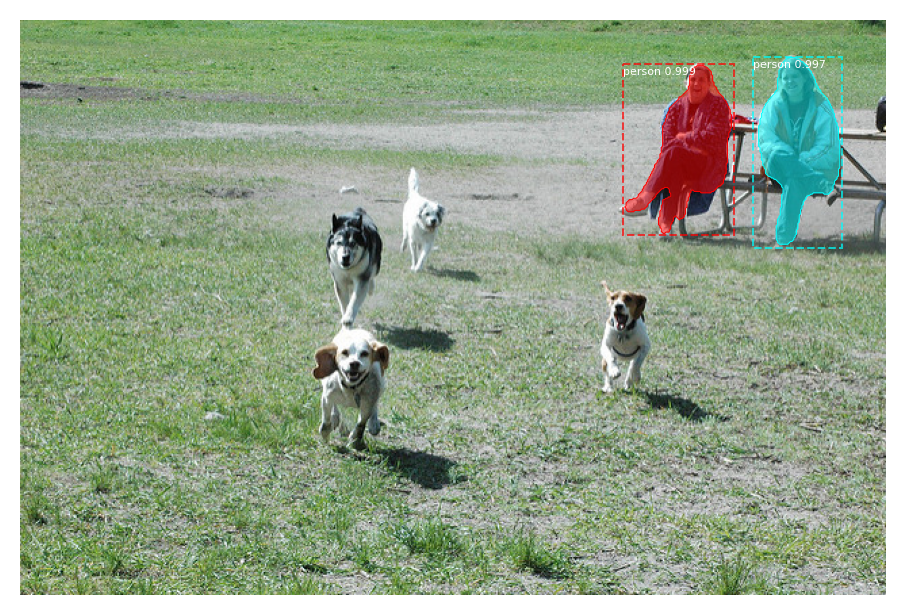

In [ ]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
result = model.detect([image], verbose=1)[0]

# Visualize results
'''
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']
'''
class_names = ['person']

result = keep_persons(result)
visualize.display_instances(image, result['rois'], result['masks'], result['class_ids'], class_names, result['scores'])

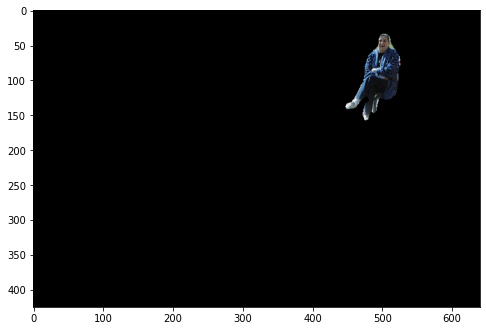

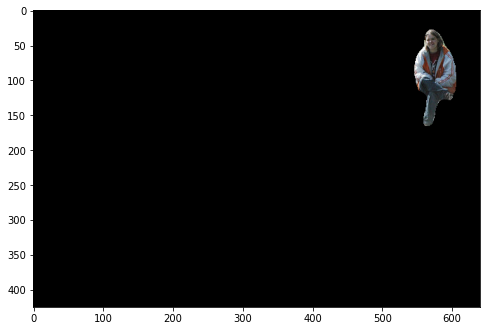

In [ ]:
import imutils

def show_mask(r,image):
    mask = r['masks']
    for i in range(mask.shape[2]):
        #temp = imutils.resize(image, width = 500)
        temp = image.copy()
        for j in range(temp.shape[2]):
            temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
        plt.figure(figsize=(8,8))
        plt.imshow(temp)
        #cv2.imwrite("./images/mask"+str(i)+".png",temp)
        plt.show()

show_mask(result,image)

### **CAMERA CAPTURE - A SINGLE IMAGE**

In [ ]:
'''
## Camera Capture
Using a webcam to capture images for processing on the runtime.
Source: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi
'''

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      // show the video in the HTML element
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // prints the logs to cell
      let jsLog = function(abc) {
        document.querySelector("#output-area").appendChild(document.createTextNode(`${abc}... `));
      }

      // Wait for Capture to be clicked.
      // await new Promise((resolve) => capture.onclick = resolve);

      for (let i = 0; i < 5; i++) {
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        img = canvas.toDataURL('image/jpeg', quality);

        // show each captured image
        // let imgTag = document.createElement('img');
        // imgTag.src = img;
        // div.appendChild(imgTag);

        jsLog(i + "sending")
        // Call a python function and send this image
        google.colab.kernel.invokeFunction('notebook.run_algo', [img], {});
        jsLog(i + "SENT")

        // wait for X miliseconds second, before next capture
        await new Promise(resolve => setTimeout(resolve, 250));
      }

      stream.getVideoTracks()[0].stop(); // stop video stream
    }
    ''')
  display(js) # make the provided HTML, part of the cell
  data = eval_js('takePhoto({})'.format(quality)) # call the takePhoto() JavaScript function

In [ ]:
import IPython
from google.colab import output
from google.colab.patches import cv2_imshow

import time
import sys
import numpy as np
import cv2

from PIL import Image
from io import BytesIO
import base64
import logging

def data_uri_to_img(uri):
  """convert base64image to numpy array"""
  try:
    image = base64.b64decode(uri.split(',')[1], validate=True)
    # make the binary image, a PIL image
    image = Image.open(BytesIO(image))
    # convert to numpy array
    image = np.array(image, dtype=np.uint8); 
    return image
  except Exception as e:
    logging.exception(e);print('\n')
    return None

def run_algo(imgB64):
  """
  in Colab, run_algo function gets invoked by the JavaScript, that sends N images every second

  params:
    image: image
  """
  image = data_uri_to_img(imgB64)  
  if image is None:
    print("At run_algo(): image is None.")
    return

  try:
    # Run detection
    results = model.detect([image], verbose=1)
    # Visualize results
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

  except Exception as e:
    logging.exception(e)
    print('\n')

# register this function, so JS code could call this
output.register_callback('notebook.run_algo', run_algo)

# put the JS code in cell and run it
take_photo()

Output hidden; open in https://colab.research.google.com to view.

### **CAPUTRE VIDEO WITH CAMERA**

In [1]:
VideoFile = '../../drive/MyDrive/Colab Notebooks/IMG_9153.MOV'

In [4]:
import cv2
from google.colab.patches import cv2_imshow
cap = cv2.VideoCapture(VideoFile)

i=0
while(True):
    i+=1
    print(i)
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
      break
    # Our operations on the frame come here
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Display the resulting frame
    #cv2_imshow(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

1


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


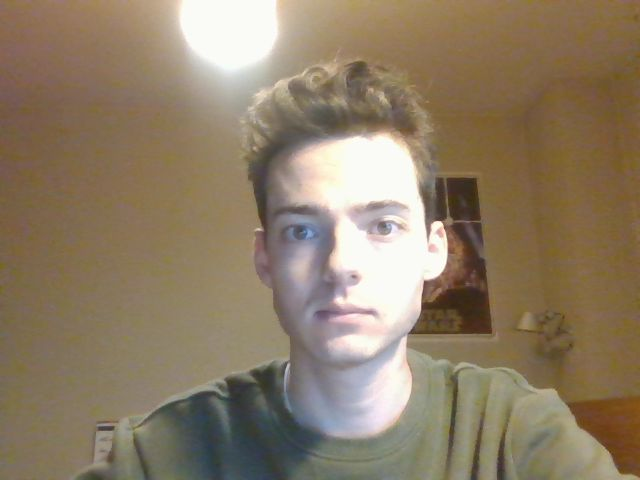

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))